In [2]:
import random
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
from importlib import reload

import gym
import matplotlib.pyplot as plt
import wandb
import torch

from Learning.utils import ReplayBuffer, plot, plot_test_trajectory, PER_IS_ReplayBuffer
import Learning.agents as ag
import Envs.AYS.AYS_Environment as ays

In [11]:
UPDATE_ONLINE = False
BATCH_SIZE = 256
MAX_EPISODES = 2000
RANDOM_EXPERIENCE = 0
LEARNING_RATE = 3e-4
BUFFER_SIZE = 2**14
REWARD_TYPE = 'PB'
DT = 1
SCHEDULER = (False, 1000, 0.5)
SEED = 0
MAX_STEPS = 600

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

wandbsave = False

config = {
    "learning_rate": LEARNING_RATE,
    "max_episodes": MAX_EPISODES,
    "batch_size": BATCH_SIZE, 
    "online_updating": UPDATE_ONLINE,
    "random_experience": RANDOM_EXPERIENCE,
    "buffer_size": BUFFER_SIZE,
    "reward_type": REWARD_TYPE,
    "dt": DT,
    "scheduler": SCHEDULER,
    "seed": SEED
}
reload(ays)
env = ays.AYS_Environment(discount=0.99,dt=DT, reward_type=REWARD_TYPE)
state_dim = len(env.observation_space)
action_dim = len(env.action_space)

reload(ag)
memory = PER_IS_ReplayBuffer(BUFFER_SIZE, alpha=0.6)
agent = ag.A2C(state_dim, action_dim, alpha=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.StepLR(agent.optimizer, step_size=SCHEDULER[1], gamma=SCHEDULER[2])

if wandbsave:
    wandb.init(name="AYS_PPO2_policy_cost",config=config,
               entity="climate_policy_optim",  project="AYS_learning")
    wandb.watch(agent.ac_net)

Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


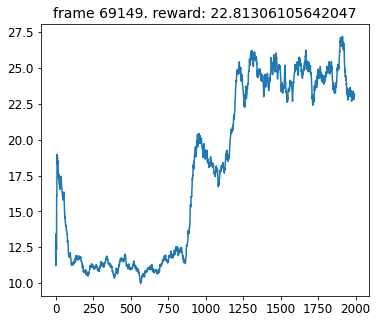

In [12]:
rewards = []
mean_rewards = []
frame_idx = 0
beta = 0.6

for episodes in tqdm(range(MAX_EPISODES)):
    state = env.reset()
    episode_reward = 0
    done = False

    for i in range(MAX_STEPS):
        if episodes>RANDOM_EXPERIENCE:
            action = agent.get_action(state)
        else:
            action = np.random.choice(action_dim)
            
        next_state, reward, done,  = env.step(action)
        
        
        episode_reward += reward
        
        if UPDATE_ONLINE:
            loss = agent.online_update((state, action, reward, next_state, done))
            if wandbsave:
                wandb.log({'loss': loss})
        else:
            memory.push(state, action, reward, next_state, done)
            
        
        state = next_state
        frame_idx += 1 
        if done:
            break
        
    rewards.append(episode_reward)
    mean_rewards.append(np.mean(rewards[-50:]))
    
    if not UPDATE_ONLINE:
        if memory.size > BATCH_SIZE:
            beta = 1-0.4*np.exp(-0.001*episodes) # we converge beta to 1
            sample = memory.sample(BATCH_SIZE, beta)
            loss, tds = agent.update((sample['obs'], sample['action'], sample['reward'], sample['next_obs'], sample['done']))
            new_tds = np.abs(tds.cpu().numpy()) + 1e-6 # compatibility
            memory.update_priorities(sample['indexes'], new_tds)
            if wandbsave:
                wandb.log({'loss': loss})    
                
    if SCHEDULER[0]:
        scheduler.step()
    
    if wandbsave:
        wandb.log({'episode_reward':episode_reward})
        if episodes%200==0:
                plot_test_trajectory(env, agent)
            
    else:
        if episodes%10==0:
            plot(frame_idx, mean_rewards)
            if episodes%30==0:
                plot_test_trajectory(env, agent)

if wandbsave:
    wandb.run.summary["mean_reward"] = np.mean(rewards)
    wandb.run.summary["top_reward"]= max(rewards)
    wandb.finish()

# Using function

In [1]:
from importlib import reload
import learn_class as lc
from Learning import utils as us

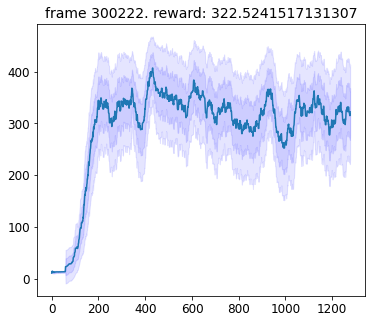

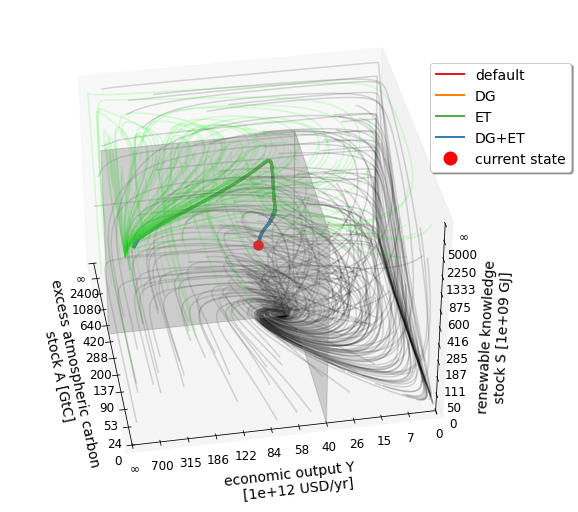

In [2]:
reload(lc)
experiment = lc.Learning(max_frames=3e5, verbose=False, max_epochs=75, seed=0, reward_type='PB')
experiment.set_agent("DuelDDQN")
experiment.learning_loop_offline(64, 10000, per_is=True, plotting=True, notebook=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.47it/s]
No handles with labels found to put in legend.


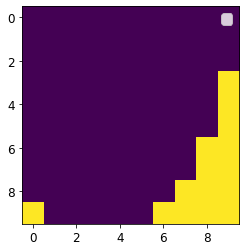

In [4]:
experiment.test_agent()

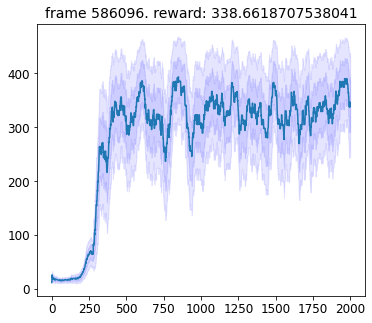

In [12]:
reload(lc)
experiment = lc.learning(wandb_save=False, max_epochs=50, max_frames=1e6, max_episodes=2000, reward_type="PB", labda=0.75, seed=1, gamma=0.9)
experiment.set_agent("PPOsplit", epsilon=0.001, clip=0.2, actor_gamma=0.9, critic_gamma=0.9, critic_param=1., gamma=0.9, lr=0.001, lr_critic=0.008, max_grad_norm=100,)
rewards = experiment.learning_loop_rollout(batch_size=32, buffer_size=1024, notebook=True, plotting=True)

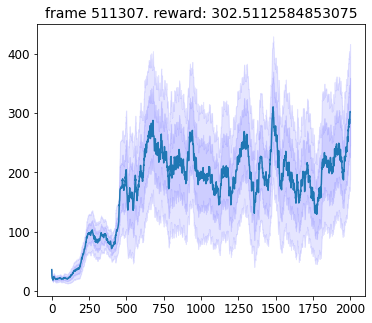

In [13]:
reload(lc)
experiment = lc.learning(wandb_save=False, max_epochs=50, max_frames=1e6, max_episodes=2000, reward_type="PB", labda=0.75, seed=2)
experiment.set_agent("PPOsplit", epsilon=0.001, clip=0.2, actor_gamma=0.9, critic_gamma=0.9, critic_param=1., gamma=0.9, lr=0.001, lr_critic=0.008, max_grad_norm=100,)
rewards = experiment.learning_loop_rollout(batch_size=32, buffer_size=1024, notebook=True, plotting=True)

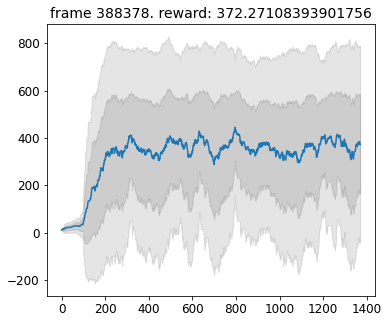

KeyboardInterrupt: 

In [3]:
reload(lc)
experiment = lc.learning(wandb_save=False, max_epochs=75, max_frames=1e5, max_episodes=2000, reward_type="PB")
experiment.set_agent("DuelDQN", epsilon=0.411, lr=0.0015, polyak=False, tau=0.042, rho=0.81)
rewards2 = experiment.learning_loop_offline("DuelDQN", batch_size=64, buffer_size=65536, per_is=True, notebook=True, plotting=True, alpha=0.42, beta=0.236)

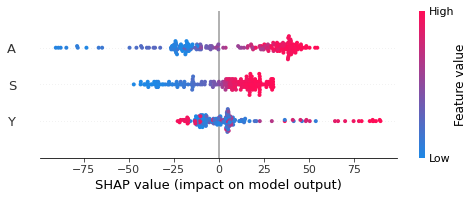

In [9]:
reload(us)
us.feature_importance(experiment.agent.actor, experiment.memory, n_points=200)

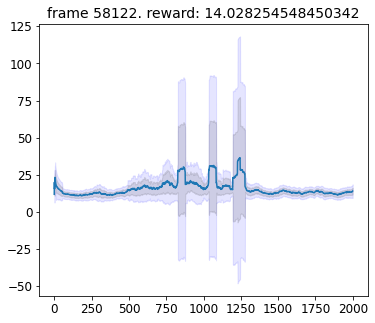

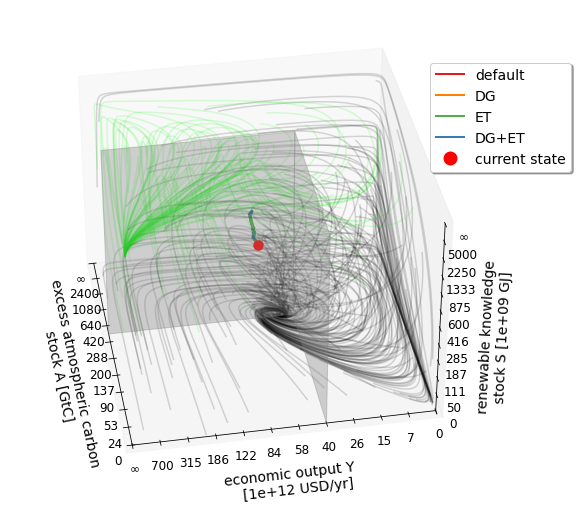

In [11]:
reload(lc)
experiment = lc.learning(wandb_save=False, max_frames=1e5, reward_type="PB")
experiment.set_agent("A2Csplit", epsilon=0.001, lr=0.0003, tau=1e5)
rewards2 = experiment.learning_loop_online("A2Csplit", notebook=True, plotting=True)

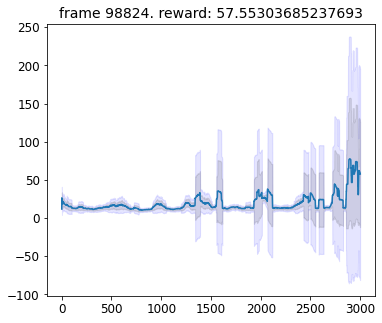

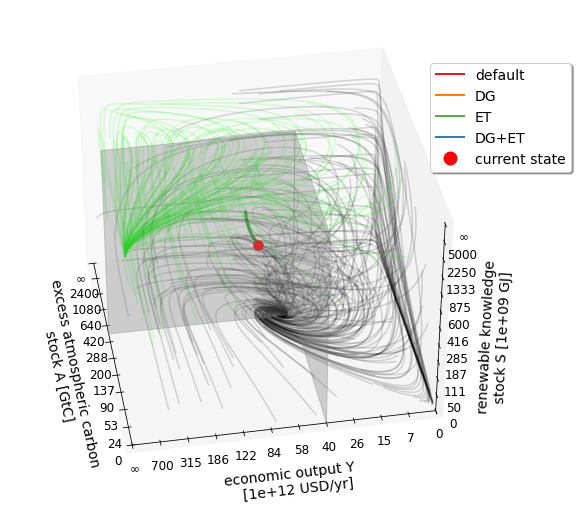

In [3]:
reload(lc)
experiment = lc.learning(wandb_save=False, max_frames=1e5, max_episodes=3000, reward_type="PB")
experiment.set_agent("PPOsplit", epsilon=0.2, lr=0.001, tau=1e5)
rewards2 = experiment.learning_loop_online("PPOsplit", notebook=True, plotting=True)

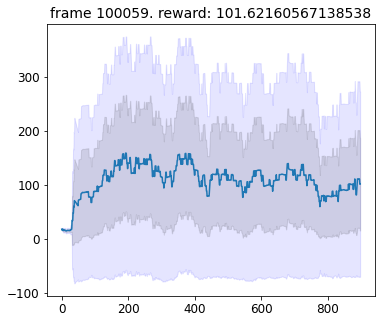

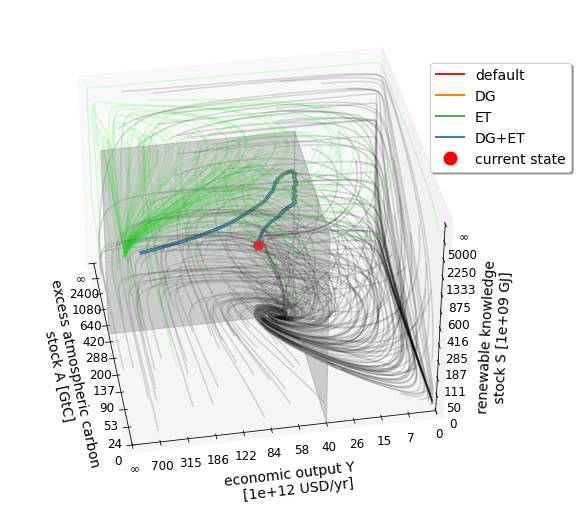

In [4]:
rewards2 = experiment.learning_loop_online("PPOsplit", notebook=True, plotting=True)

In [12]:
import numpy as np
n=10
data = np.zeros((3, n**3))
for i in range(n):
    for j in range(n):
        for k in range(n):
            data[:,i*100+j*10+k] = np.array([i/n, j/n, k/n])
data = data.T

(300, 3)


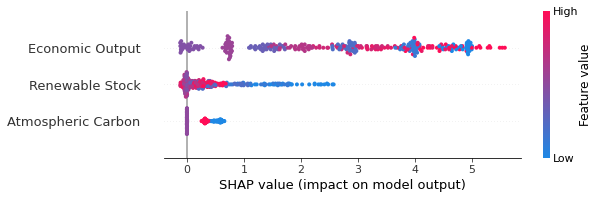

In [18]:
import torch
import shap
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


features = ["Atmospheric Carbon", "Economic Output", "Renewable Stock"]

explainer = shap.DeepExplainer(experiment.agent.actor,
                               torch.from_numpy(data[:300]).float().to(DEVICE))
shap_q_values = explainer.shap_values(torch.from_numpy(data[:300]).float().to(DEVICE))
shap_values = np.array(np.max(shap_q_values, axis=0))
# df = pd.DataFrame({
#     "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
#     "stdev_abs_shap": np.std(np.abs(shap_values), axis=0),
#     "name": features
# })
print(shap_values.shape)
shap.summary_plot(shap_values, features=data[:300], feature_names=features)

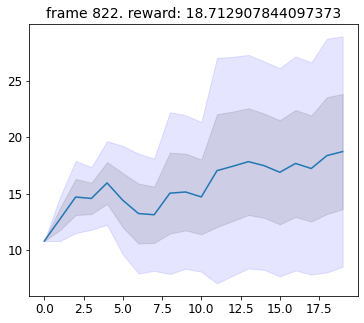

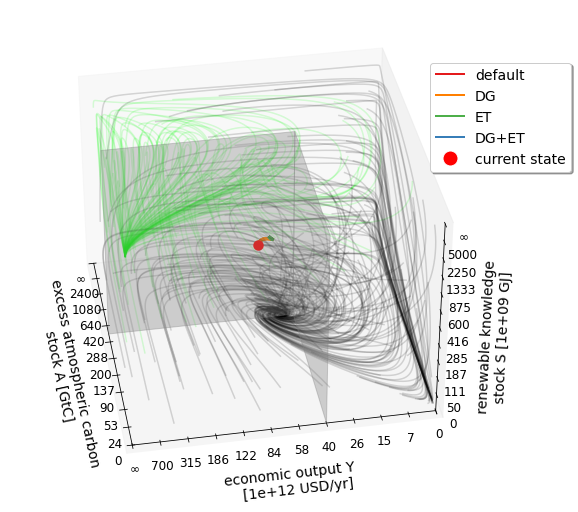

In [19]:
reload(lc)
experiment2 = lc.learning(wandb_save=False, max_epochs=75, max_frames=1e5, max_episodes=20, reward_type="PB")
experiment2.set_agent("DuelDQN", epsilon=0.411, lr=0.0015, polyak=False, tau=0.042, rho=0.81)
rewards2 = experiment2.learning_loop_offline("DuelDQN", batch_size=64, buffer_size=65536, per_is=True, notebook=True, plotting=True, alpha=0.42, beta=0.236)

(300, 3)


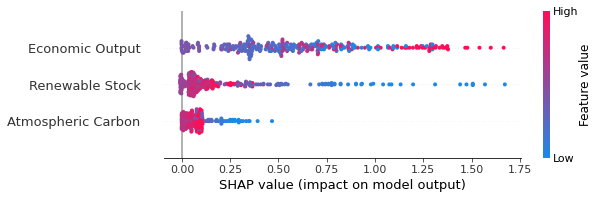

In [24]:
data = experiment2.memory.sample(300, 1)['obs']
features = ["Atmospheric Carbon", "Economic Output", "Renewable Stock"]

explainer = shap.DeepExplainer(experiment.agent.actor,
                               torch.from_numpy(data).float().to(DEVICE))
shap_q_values = explainer.shap_values(torch.from_numpy(data).float().to(DEVICE))
shap_values = np.array(np.max(shap_q_values, axis=0))

print(shap_values.shape)
shap.summary_plot(shap_values, features=data, feature_names=features)